### Домашнее задание 8

1.   Возьмите англо-русскую пару фраз
2.   Обучите на них seq2seq with attention:

● на основе скалярного произведения

● на основе MLP

3. Оцените качество

In [1]:
from IPython.display import clear_output

In [2]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
clear_output()

In [3]:
%load_ext pycodestyle_magic

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from itertools import chain
from tqdm.notebook import tqdm
from warnings import filterwarnings
from datetime import datetime, timedelta

%matplotlib inline

In [5]:
filterwarnings('ignore')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
!wget https://www.manythings.org/anki/rus-eng.zip

--2022-09-02 12:53:44--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14819554 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.13M  10.3MB/s    in 1.4s    

2022-09-02 12:53:45 (10.3 MB/s) - ‘rus-eng.zip’ saved [14819554/14819554]



In [8]:
!unzip rus-eng.zip

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [9]:
!rm rus-eng.zip _about.txt

In [10]:
df = pd.read_csv('rus.txt', sep='\t', header=None).drop(2, axis=1)

In [11]:
df.head(10)

,0,1
0,Go.,Марш!
1,Go.,Иди.
2,Go.,Идите.
3,Hi.,Здравствуйте.
4,Hi.,Привет!
5,Hi.,Хай.
6,Hi.,Здрасте.
7,Hi.,Здоро́во!
8,Hi.,Приветик!
9,Run!,Беги!


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444587 entries, 0 to 444586
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       444587 non-null  object
 1   1       444587 non-null  object
dtypes: object(2)
memory usage: 6.8+ MB


In [13]:
df[0] = df[0].apply(lambda x: re.sub(r'[^a-zа-яё \']+', '', x.lower()))
df[1] = df[1].apply(lambda x: re.sub(r'[^a-zа-яё \']+', '', x.lower()))
df[0] = df[0].apply(lambda x: re.sub(r'\s\s+|\'', ' ', x))
df[1] = df[1].apply(lambda x: re.sub(r'\s\s+|\'', ' ', x))

In [14]:
df.sample(n=10)

,0,1
18203,should we sing,нам спеть
353433,what do you know about winter sports,что тебе известно о зимних видах спорта
205001,do you think that scares me,думаешь меня это пугает
48210,tom isn t leaving,том не уходит
440509,i managed to find a parking place right in fro...,мне удалось найти место для парковки прямо нап...
314674,the room became filled with smoke,комната наполнилась дымом
425667,are you sure you don t want to go swimming wit...,ты уверен что не хочешь пойти с нами поплавать
165809,you have to learn french,вы должны выучить французский язык
422122,the books that you re looking for are on my desk,книги которые ты ищешь лежат у меня на столе
72443,is that a challenge,это вызов


In [15]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [16]:
pairs = list(zip(df[0].tolist(), df[1].tolist()))

In [17]:
del df

In [18]:
pairs = filterPairs(pairs)

In [19]:
len(pairs)

28107

In [20]:
eng_dict = ['SOS', 'EOS'] + sorted(
    list(set(chain.from_iterable([pair[0].split() for pair in pairs])))
    )

In [21]:
len(eng_dict)

4367

In [22]:
eng_dict[:10]

['SOS',
 'EOS',
 'a',
 'abandon',
 'ability',
 'able',
 'aboard',
 'about',
 'above',
 'abroad']

In [23]:
rus_dict = ['SOS', 'EOS'] + sorted(
    list(set(chain.from_iterable([pair[1].split() for pair in pairs])))
    )

In [24]:
len(rus_dict)

10478

In [25]:
rus_dict[:10]

['SOS',
 'EOS',
 'android',
 'linux',
 'windows',
 'а',
 'абсолютно',
 'абсолютной',
 'авантюрен',
 'авантюризма']

In [26]:
eng_to_idx = {elem: i for i, elem in enumerate(eng_dict)}
rus_to_idx = {elem: i for i, elem in enumerate(rus_dict)}

In [27]:
def tensors_from_pair(pair):
    eng_idx = [0] + [eng_to_idx[word] for word in pair[0].split()]
    eng_idx += [1] * (MAX_LENGTH + 1 - len(pair[0].split()))
    rus_idx = [0] + [rus_to_idx[word] for word in pair[1].split()]
    rus_idx += [1] * (MAX_LENGTH + 1 - len(pair[1].split()))
    eng_tensor = torch.tensor(eng_idx, dtype=torch.long,
                              device=device).view(-1, 1)
    rus_tensor = torch.tensor(rus_idx, dtype=torch.long,
                              device=device).view(-1, 1)
    return (eng_tensor, rus_tensor)

In [28]:
pair = pairs[np.random.randint(27003)]
print(pair)
print(tensors_from_pair(pair))

('i m really excited for tom', 'я очень рад за тома')
(tensor([[   0],
        [1905],
        [2294],
        [3048],
        [1314],
        [1500],
        [3940],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1]], device='cuda:0'), tensor([[    0],
        [10431],
        [ 5655],
        [ 7484],
        [ 2283],
        [ 9244],
        [    1],
        [    1],
        [    1],
        [    1],
        [    1],
        [    1]], device='cuda:0'))


##### Encoder

In [29]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

##### Attention Decoder (на скалярном произведении)

In [30]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1,
                 max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length + 2

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        weights = []
        for i in range(len(encoder_outputs)):
            weights.append(
                torch.div(torch.matmul(hidden[0][0], encoder_outputs[i]),
                          torch.sqrt(
                              torch.tensor(self.max_length, dtype=torch.float,
                                           device=device))
                          )
                )
        attn_weights = F.softmax(torch.tensor(weights, device=device))

        attn_applied = torch.bmm(attn_weights.unsqueeze(0).unsqueeze(0),
                                 encoder_outputs.view(1, -1, self.hidden_size)
                                 )

        output = torch.cat((attn_applied[0], embedded[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

##### Функции для обучения и оценки качества

In [31]:
teacher_forcing_ratio = 0.5

In [32]:
def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion, max_len=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs = torch.zeros(max_len + 2, encoder.hidden_size,
                                  device=device)
    loss = 0

    for i in range(input_tensor.size(0)):
        encoder_output, encoder_hidden = encoder(input_tensor[i],
                                                 encoder_hidden)
        encoder_outputs[i] = encoder_output[0, 0]

    decoder_input = torch.tensor([[0]], device=device)
    decoder_hidden = encoder_hidden

    if np.random.random() < teacher_forcing_ratio:
        use_teacher_forcing = True
    else:
        use_teacher_forcing = False

    for i in range(target_tensor.size(0)):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs
            )
        loss += criterion(decoder_output, target_tensor[i])
        if use_teacher_forcing:
            # teacher forcing: feed the target as the next input
            decoder_input = target_tensor[i]
        else:
            # use its own predictions as the next input
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            if decoder_input.item() == 1:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_tensor.size(0)

In [33]:
def train_epochs(encoder, decoder, n_epochs=75000, learning_rate=0.01):
    start = datetime.now()
    plot_losses = []
    print_loss = 0 # reset every 5000 epochs
    plot_loss = 0 # reset every 100 epochs
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensors_from_pair(pairs[np.random.randint(27003)])
                      for epoch in range(n_epochs)]
    criterion = nn.NLLLoss()

    for epoch in tqdm(range(n_epochs)):
        training_pair = training_pairs[epoch]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        print_loss += loss
        plot_loss += loss

        if (epoch + 1) % 5000 == 0:
            print_loss /= 5000
            delta = datetime.now() - start
            stats = f'''
            Epoch {epoch + 1} ({(epoch + 1) * 100 / n_epochs:.1f}%)
            Time: {delta.seconds // 60}m {delta.seconds % 60}s
            Loss: {print_loss:.4f}
            '''
            print(stats)
            print_loss = 0

        if (epoch + 1) % 100 == 0:
            plot_loss /= 100
            plot_losses.append(plot_loss)
            plot_loss = 0
    return plot_losses

In [34]:
def show_losses(losses):
    plt.figure(figsize=(14, 12))
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(losses)
    plt.show()

In [35]:
def evaluate(encoder, decoder, sent, max_len=MAX_LENGTH):
    with torch.no_grad():
        idx = [0] + [eng_to_idx[word] for word in sent.split()]
        idx += [1] * (max_len + 1 - len(sent.split()))
        input_tensor = torch.tensor(idx, dtype=torch.long,
                                    device=device).view(-1, 1)
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_len + 2, encoder.hidden_size,
                                      device=device)

        for i in range(input_tensor.size()[0]):
            encoder_output, encoder_hidden = encoder(input_tensor[i],
                                                     encoder_hidden)
            encoder_outputs[i] = encoder_output[0, 0]

        decoder_input = torch.tensor([[0]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_len + 2, max_len + 2)

        for i in range(max_len + 2):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[i] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == 1:
                break
            decoded_words.append(rus_dict[topi.item()])
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions

In [36]:
def evaluate_random(encoder, decoder, n=10):
    for i in range(n):
        pair = pairs[np.random.randint(27003)]
        pred = " ".join(evaluate(encoder, decoder, pair[0])[0][1:])
        res = f'''
        Eng:  {pair[0]}
        Rus:  {pair[1]}
        Pred: {pred}
        '''
        print(res)

##### Обучение и оценка качества

In [37]:
hidden_size = 256

In [38]:
encoder = EncoderRNN(len(eng_dict), hidden_size).to(device)

In [39]:
attn_decoder = AttnDecoderRNN(hidden_size, len(rus_dict)).to(device)

In [40]:
losses = train_epochs(encoder, attn_decoder)

  0%|          | 0/75000 [00:00<?, ?it/s]


            Epoch 5000 (6.7%)
            Time: 2m 52s
            Loss: 1.9219
            

            Epoch 10000 (13.3%)
            Time: 5m 40s
            Loss: 1.7428
            

            Epoch 15000 (20.0%)
            Time: 8m 20s
            Loss: 1.5992
            

            Epoch 20000 (26.7%)
            Time: 10m 53s
            Loss: 1.5071
            

            Epoch 25000 (33.3%)
            Time: 13m 26s
            Loss: 1.3904
            

            Epoch 30000 (40.0%)
            Time: 15m 59s
            Loss: 1.3013
            

            Epoch 35000 (46.7%)
            Time: 18m 33s
            Loss: 1.2446
            

            Epoch 40000 (53.3%)
            Time: 21m 5s
            Loss: 1.1701
            

            Epoch 45000 (60.0%)
            Time: 23m 40s
            Loss: 1.1260
            

            Epoch 50000 (66.7%)
            Time: 26m 13s
            Loss: 1.0846
            

            Epoch 55000 (73.3%)
   

<Figure size 1008x864 with 0 Axes>

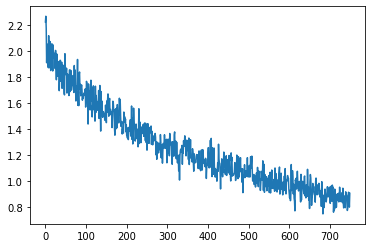

In [41]:
show_losses(losses)

Лосс стабильно падает, финальный лосс – 0.8726. Посмотрим на генерацию предложений.

In [42]:
evaluate_random(encoder, attn_decoder)


        Eng:  i m tired of your endless complaints
        Rus:  я устала от ваших бесконечных жалоб
        Pred: я устал от твоих бесконечных жалоб
        

        Eng:  i m still active
        Rus:  я попрежнему активна
        Pred: я ещё учусь
        

        Eng:  i m not giving you any money
        Rus:  не дам я тебе никаких денег
        Pred: я не собираюсь тебе никаких денег
        

        Eng:  you re a good kisser
        Rus:  вы хорошо целуетесь
        Pred: ты хороший целуешься
        

        Eng:  i m sorry i just wanted to help
        Rus:  извините я просто хотел помочь
        Pred: я очень рад что могу помочь помочь
        

        Eng:  you re my guest
        Rus:  ты мой гость
        Pred: ты же в гостях
        

        Eng:  she is busy learning english
        Rus:  она занята изучением английского языка
        Pred: она занята занята английского
        

        Eng:  we aren t blaming you
        Rus:  мы вас не обвиняем
        Pred: м

Два случайное предложение переведено полностью правильно, и 3 – правильно по смыслу (если учесть, что в английском нет родов и разграничения на "ты" и "вы")!

In [43]:
pair = pairs[np.random.randint(27003)]
print(pair)

('you re aggressive', 'ты агрессивна')


In [44]:
output_words, attentions = evaluate(
    encoder, attn_decoder, pair[0])

In [45]:
attentions

tensor([[2.8687e-21, 8.4738e-20, 1.6695e-16, 1.8523e-10, 3.0607e-06, 4.9736e-04,
         1.1925e-02, 5.9842e-02, 1.3450e-01, 2.0825e-01, 2.6908e-01, 3.1589e-01],
        [2.9827e-14, 3.6826e-13, 2.8067e-10, 1.0411e-04, 3.5302e-03, 3.2631e-02,
         1.0815e-01, 1.5864e-01, 1.7414e-01, 1.7626e-01, 1.7457e-01, 1.7199e-01],
        [2.3576e-10, 1.0962e-09, 2.7246e-07, 1.2226e-01, 1.0756e-01, 1.5954e-01,
         1.7549e-01, 1.3288e-01, 9.9430e-02, 7.9104e-02, 6.6228e-02, 5.7511e-02],
        [5.9151e-09, 1.0061e-07, 2.4713e-05, 7.8311e-01, 2.8675e-02, 2.5668e-02,
         3.4379e-02, 3.2194e-02, 2.8276e-02, 2.4990e-02, 2.2378e-02, 2.0305e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0

In [46]:
attentions.numpy()[0]

array([2.8686811e-21, 8.4737668e-20, 1.6695166e-16, 1.8522761e-10,
       3.0607275e-06, 4.9735745e-04, 1.1925121e-02, 5.9842423e-02,
       1.3450402e-01, 2.0825160e-01, 2.6908463e-01, 3.1589177e-01],
      dtype=float32)

<Figure size 1008x864 with 0 Axes>

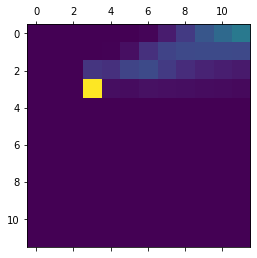

In [47]:
plt.figure(figsize=(14, 12))
plt.matshow(attentions.numpy())
plt.show()

In [48]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words + ['<EOS>'])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [49]:
def evaluate_show_attention(sent):
    output_words, attentions = evaluate(
        encoder, attn_decoder, sent)
    print('input =', sent)
    print('output =', ' '.join(output_words[1:]))
    showAttention(sent, output_words[1:], attentions)

input = i m sorry for calling so late
output = простите что опоздал


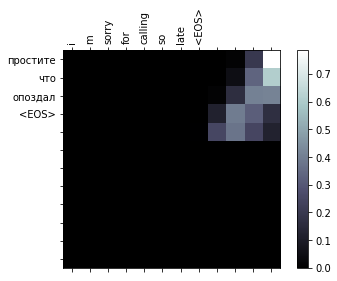

In [50]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = she sat beside me in church
output = она в она в в


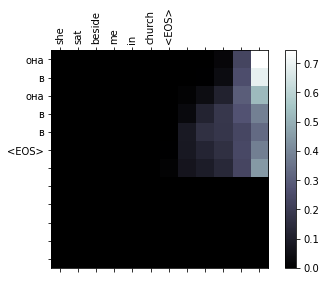

In [51]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = i m trying to get someone to help me
output = я пытаюсь кто это сделать


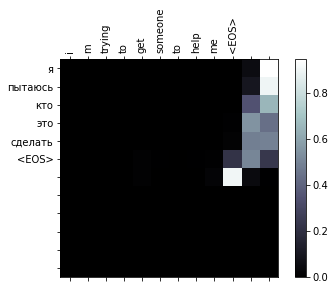

In [52]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = she s stark naked
output = она в себя


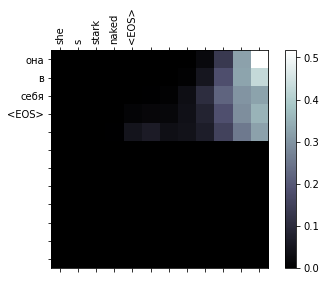

In [53]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

Очень много attention у токенов EOS, добавленных для паддинга предложений до одинаковой длины. Из-за этого на графиках attention у слов предложения не видно. Но оно есть!

##### Attention Decoder (на MLP)

In [54]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.attn = nn.Linear(self.hidden_size * 2, 1)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        weights = []
        for i in range(len(encoder_outputs)):
            weights.append(
                torch.tanh(self.attn(torch.cat((hidden[0][0],
                                                encoder_outputs[i]))))
                )
        attn_weights = F.softmax(torch.tensor(weights, device=device))

        attn_applied = torch.bmm(attn_weights.unsqueeze(0).unsqueeze(0),
                                 encoder_outputs.view(1, -1, self.hidden_size)
                                 )

        output = torch.cat((attn_applied[0], embedded[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

##### Обучение и оценка качества

In [55]:
hidden_size = 256

In [56]:
encoder = EncoderRNN(len(eng_dict), hidden_size).to(device)

In [57]:
attn_decoder = AttnDecoderRNN(hidden_size, len(rus_dict)).to(device)

In [58]:
losses = train_epochs(encoder, attn_decoder)

  0%|          | 0/75000 [00:00<?, ?it/s]


            Epoch 5000 (6.7%)
            Time: 2m 41s
            Loss: 1.9628
            

            Epoch 10000 (13.3%)
            Time: 5m 19s
            Loss: 1.7567
            

            Epoch 15000 (20.0%)
            Time: 7m 58s
            Loss: 1.6388
            

            Epoch 20000 (26.7%)
            Time: 10m 39s
            Loss: 1.5332
            

            Epoch 25000 (33.3%)
            Time: 13m 20s
            Loss: 1.4429
            

            Epoch 30000 (40.0%)
            Time: 16m 1s
            Loss: 1.3493
            

            Epoch 35000 (46.7%)
            Time: 18m 40s
            Loss: 1.2913
            

            Epoch 40000 (53.3%)
            Time: 21m 24s
            Loss: 1.2283
            

            Epoch 45000 (60.0%)
            Time: 24m 8s
            Loss: 1.1568
            

            Epoch 50000 (66.7%)
            Time: 26m 52s
            Loss: 1.1162
            

            Epoch 55000 (73.3%)
    

<Figure size 1008x864 with 0 Axes>

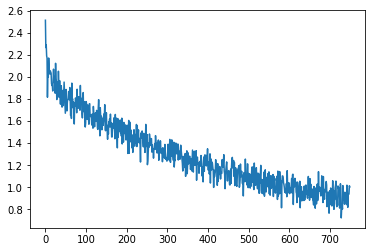

In [59]:
show_losses(losses)

Обучается чуть-чуть дольше, чем seq2seq с attention на скалярном произведении (40 минут 31 секунд против 39 минут 8 секунд), финальный loss хуже, чем у сети с attention на скалярном произведении (0.9188 против 0.8726). Посмотрим на генерацию предложений.

In [60]:
evaluate_random(encoder, attn_decoder)


        Eng:  you re not going to wear that are you
        Rus:  ты ведь не собираешься это носить правда
        Pred: ты ведь не собираешься
        

        Eng:  they re the only ones tom can trust
        Rus:  они единственные кому том может доверять
        Pred: ты единственный кому кому доверять
        

        Eng:  i m glad the rumors weren t true
        Rus:  я рад что слухи не подтвердились
        Pred: я рад что что не не
        

        Eng:  you re making a serious mistake
        Rus:  вы совершаете серьёзную ошибку
        Pred: ты совершаешь ошибку ошибку
        

        Eng:  we re not the murderers
        Rus:  мы не убийцы
        Pred: мы не не
        

        Eng:  i m younger than he is
        Rus:  я моложе его
        Pred: я моложе него
        

        Eng:  you re not my friend
        Rus:  ты мне не друг
        Pred: ты мне не подруга
        

        Eng:  he is dead and buried now
        Rus:  сейчас он мёртв и предан земле
        P

Предсказания тоже хуже, среди всех сгенерированных предложений только одно переведено правильно (в точности или по смыслу).

In [61]:
pair = pairs[np.random.randint(27003)]
print(pair)

('you re twice as old as tom', 'вы в два раза старше тома')


In [62]:
output_words, attentions = evaluate(
    encoder, attn_decoder, pair[0])

In [63]:
attentions

tensor([[0.0746, 0.0554, 0.0621, 0.0616, 0.1201, 0.0705, 0.0921, 0.0981, 0.0825,
         0.0893, 0.0951, 0.0985],
        [0.0747, 0.0546, 0.0617, 0.0612, 0.1197, 0.0705, 0.0925, 0.0984, 0.0828,
         0.0896, 0.0955, 0.0988],
        [0.0751, 0.0539, 0.0615, 0.0610, 0.1183, 0.0707, 0.0928, 0.0986, 0.0833,
         0.0901, 0.0957, 0.0989],
        [0.0748, 0.0578, 0.0636, 0.0632, 0.1193, 0.0711, 0.0912, 0.0970, 0.0821,
         0.0885, 0.0941, 0.0974],
        [0.0764, 0.0640, 0.0681, 0.0678, 0.1131, 0.0736, 0.0890, 0.0937, 0.0819,
         0.0869, 0.0914, 0.0941],
        [0.0759, 0.0626, 0.0671, 0.0668, 0.1148, 0.0730, 0.0895, 0.0945, 0.0819,
         0.0872, 0.0920, 0.0948],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [64]:
attentions.numpy()[0]

array([0.0746269 , 0.05541841, 0.06207777, 0.06162554, 0.1200615 ,
       0.07050007, 0.09213413, 0.09809936, 0.08252174, 0.08928889,
       0.09514069, 0.09850496], dtype=float32)

<Figure size 1008x864 with 0 Axes>

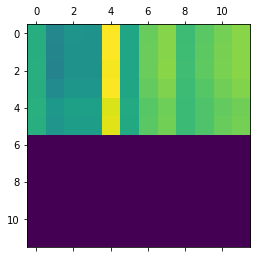

In [65]:
plt.figure(figsize=(14, 12))
plt.matshow(attentions.numpy())
plt.show()

input = you re a complete idiot
output = ты врач


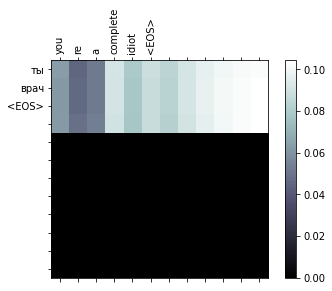

In [66]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = you re twice as old as i am
output = ты вдвое старше меня


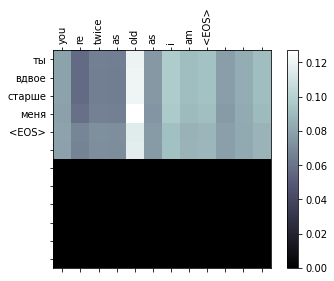

In [67]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = we re just tired
output = мы просто устали


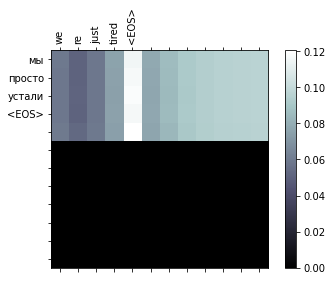

In [68]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

input = you re a true friend
output = ты настоящий друг


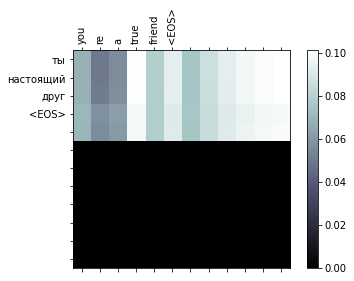

In [69]:
evaluate_show_attention(pairs[np.random.randint(27003)][0])

Зато графики attention уже больше похожи на правду – больше всего attention всё ещё у токенов EOS, добавленных в английское предложение для паддинга, но заметно, что:

*   с какого-то токена EOS attention начинает плавно уменьшаться
*   для предсказанного предложения attention ненулевое строго до токена EOS и ещё одну клетку
*   первое слово в английском предложении, как правило, обладает наименьшим attention